In [ ]:
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html

# Using Callback: Monitoring Training

You can define a custom callback function that will be called inside the agent. This could be useful when you want to monitor training, for instance display live learning curves in Tensorboard (or in Visdom) or save the best agent. If your callback returns False, training is aborted early.

In [1]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

In [3]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "timesteps")
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

In [4]:
# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

In [5]:
# Create and wrap the environment
env = gym.make("LunarLanderContinuous-v2")
env = Monitor(env, log_dir)

In [6]:
# Add some action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Because we use parameter noise, we should use a MlpPolicy with layer normalization

In [7]:
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=0)

In [8]:
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir) #check_freq=1000

In [9]:
# Train the agent
timesteps = 1000 #1e5
model.learn(total_timesteps=int(timesteps), callback=callback)

Num timesteps: 100
Best mean reward: -inf - Last mean reward per episode: -383.88
Saving new best model to tmp/best_model
Num timesteps: 200
Best mean reward: -383.88 - Last mean reward per episode: -246.86
Saving new best model to tmp/best_model
Num timesteps: 300
Best mean reward: -246.86 - Last mean reward per episode: -403.28
Num timesteps: 400
Best mean reward: -246.86 - Last mean reward per episode: -509.87
Num timesteps: 500
Best mean reward: -246.86 - Last mean reward per episode: -732.49
Num timesteps: 600
Best mean reward: -246.86 - Last mean reward per episode: -709.00
Num timesteps: 700
Best mean reward: -246.86 - Last mean reward per episode: -700.43
Num timesteps: 800
Best mean reward: -246.86 - Last mean reward per episode: -684.42
Num timesteps: 900
Best mean reward: -246.86 - Last mean reward per episode: -617.12
Num timesteps: 1000
Best mean reward: -246.86 - Last mean reward per episode: -617.12
Num timesteps: 1100
Best mean reward: -246.86 - Last mean reward per epi

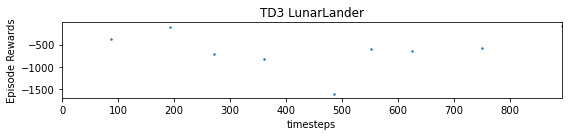

In [10]:
plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "TD3 LunarLander")
plt.show()

In [11]:
timesteps

1000

In [14]:
results_plotter.X_TIMESTEPS

'timesteps'

In [15]:
type(results_plotter.X_TIMESTEPS)

str

In [17]:
import pandas as pd

In [22]:
df = pd.read_csv('copy1_monitor.csv')

In [23]:
df

,r,l,t
0,-383.878515,88,5.487502
1,-109.831601,105,7.787711
2,-716.134066,78,8.711449
3,-829.643966,89,9.453444
4,-1622.958633,125,10.285955
5,-591.575995,66,11.383873
6,-648.963994,74,12.007304
7,-572.363827,124,12.830626
8,-78.731838,143,14.031894
9,-164.698034,258,15.535769


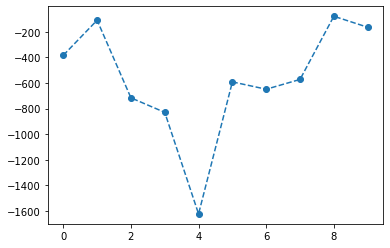

In [26]:
plt.figure()
plt.plot(df['r'], '--o')